In [3]:
#Değişkenleri azaltarak model kuruyoruz kısaca..
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import scale # Bu ve
from sklearn.decomposition import PCA #Bu kütüphaneyle yapıyoruz.

from sklearn import model_selection #Model tuning bu kütüphane ile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataframe = pd.read_csv("Hitters.csv")
df = dataframe.copy()
df=df.dropna()

In [4]:
dms=pd.get_dummies(df[['League','Division','NewLeague']])

In [5]:
y=df["Salary"]#Bağımsız değişken

In [6]:
X_ = df.drop(["Salary","League","Division","NewLeague"], axis=1).astype("float64")
#Ham kategorik değişkenler ve bağımsız değişken dataframe'den atıldı
#Dummy değişkenler ve diğer değişkenleri yani X_'i birleştiriyoruz

X = pd.concat([X_,dms[["League_N","Division_W","NewLeague_N"]]], axis=1)
#Bağımsız değişkenimiz hazır..

In [76]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [77]:
pca = PCA()

In [78]:
X_reduced_train=pca.fit_transform(scale(X_train))
#Training veri setimizi indirgedik

In [79]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)[0:10]

array([38.18, 59.88, 70.88, 78.88, 84.18, 88.45, 92.05, 94.86, 96.34,
       97.28])

In [80]:
#Bir üstteki satırda indirgenmiş veri setinin hangi 
#bileşeni varyanstaki değişimi ne kadar açıklıyor diye baktık

In [81]:
#İndirgenmiş training veri seti üzerine model kurmaya başlıyoruz.

In [82]:
reg = LinearRegression()
skmodel=reg.fit(X_reduced_train,y_train)

In [83]:
predicted_y = skmodel.predict(X_reduced_train)

In [84]:
rmse = np.sqrt(mean_squared_error(y_train,predicted_y))

In [85]:
rmse #Deli dehşet hata, eğitim hatası

289.32928255649756

In [86]:
r2_score(y_train,predicted_y)

0.577007525041018

In [87]:
pca2=PCA() #Test setini de indirgiyoruz..
X_reduced_test=pca2.fit_transform(scale(X_test))

In [88]:
predicted_y_test = skmodel.predict(X_reduced_test)

In [89]:
rmse2 = np.sqrt(mean_squared_error(y_test,predicted_y_test))

In [90]:
rmse2 #Test hatası daha boktan

405.15753641499634

In [91]:
r2_score(y_test,predicted_y_test)

0.24170463640313322

In [94]:
#Model tuning işlemleri...
#----------------------------------
#Farklı değişken sayılarında modeller kurup test hatalarının 
#nasıl değiştiğini gözlemleyeceğiz..

In [111]:
reg = LinearRegression()
skmodel=reg.fit(X_reduced_train[:,0:25],y_train)
#Sadece 1. bileşeni alıp model kurduk
predicted_y_test = skmodel.predict(X_reduced_test[:,0:25])


#Değişken sayısı değiştikçe hata değişiyor, optimal'i nasıl bulacağız ?
#Tabi ki model tuning ile !

In [112]:
cv_10=model_selection.KFold(n_splits=10,
                            shuffle=True,
                            random_state=1)

lm=LinearRegression()
RMSE =[]

In [113]:
#Scikit-learn kütüphanesinde pcr desteği olmadığı 
#için döngüyü kendimiz yazacağız.
#Ezber birazcık, kopya yapış

In [114]:
for i in np.arange(1, X_reduced_train.shape[1] + 1):
    
    score = np.sqrt(-1*model_selection.cross_val_score(lm, 
                                                       X_reduced_train[:,0:i], 
                                                       y_train.ravel(), 
                                                       cv=cv_10, 
                                                       scoring='neg_mean_squared_error').mean())
    RMSE.append(score)

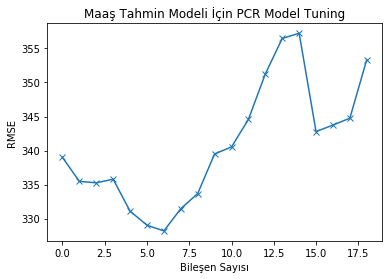

In [115]:
plt.plot(RMSE,"-x")
plt.xlabel('Bileşen Sayısı')
plt.ylabel('RMSE')
plt.title('Maaş Tahmin Modeli İçin PCR Model Tuning');

In [116]:
#Hata kareleri ortalaması en az 16 bileşenliyken oluyor

#Şimdi 16 bileşenli final modelimizi oluşturuyoruz

In [117]:
regopt=LinearRegression()
optimalmodel=regopt.fit(X_reduced_train[:,0:6],y_train)

predict_by_optimal=optimalmodel.predict(X_reduced_train[:,0:6])

In [118]:
np.sqrt(mean_squared_error(y_train,predict_by_optimal))

308.8265983094501

In [119]:
#Tune edilmiş eğitim hatası yukarıda
#Şimdi tune edilmiş test hatası geliyor

In [120]:
test_predict_by_optimal=optimalmodel.predict(X_reduced_test[:,0:6])

In [121]:
np.sqrt(mean_squared_error(y_test,test_predict_by_optimal))

393.11987000962233

In [122]:
#Test hatası düşmüş.